# 1. Import the required libraries

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [23]:
import statsmodels.api as sm

# 2. Read the data

In [3]:
train = pd.read_csv("../input/train_s3TEQDk.csv")
test = pd.read_csv("../input/test_mSzZ8RL.csv")
ss = pd.read_csv("../input/sample_submission_eyYijxG.csv")

# 3. Basic checks on the data

In [4]:
print(f"The shape of Train dataset : {train.shape}")
print(f"The shape of Test dataset : {test.shape}")
print(f"The shape of Sample submission dataset : {ss.shape}")

The shape of Train dataset : (245725, 11)
The shape of Test dataset : (105312, 10)
The shape of Sample submission dataset : (105312, 2)


Checking the first few columns on Train and Test dataset

In [5]:
train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [6]:
test.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No
1,CCMEWNKY,Male,43,RG268,Other,X2,49,NaN,925537,No
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No


Based on the data dictionary details and by seeing the data, first impressions to investigate more about,
    1. We have to check for the unique values for **Region Code** column, I think we might have more categories for it.If so we have to think about, how to deal it.
    2. Since **Channel Code** column is encoded, we might not know the actual category. If we know the categories it might be more useful for the predictions/feature engineering.
    3. We need to see if there is any correlation between **Credit Product** and **Average Account Balance** columns.
    
Thats it, other than that the dataset is simple, so feature engineering plays a very big role probably.

Lets check for any missing values

In [8]:
train.isnull().sum()

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         29325
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
dtype: int64

In [9]:
test.isnull().sum()

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         12522
Avg_Account_Balance        0
Is_Active                  0
dtype: int64

In both the train and the test datasets, we have missing values in only one column (Credit_Product). Lets see the percentage of missing values.

In [10]:
train.isnull().sum()/train.shape[0]

ID                     0.000000
Gender                 0.000000
Age                    0.000000
Region_Code            0.000000
Occupation             0.000000
Channel_Code           0.000000
Vintage                0.000000
Credit_Product         0.119341
Avg_Account_Balance    0.000000
Is_Active              0.000000
Is_Lead                0.000000
dtype: float64

In [11]:
test.isnull().sum()/test.shape[0]

ID                     0.000000
Gender                 0.000000
Age                    0.000000
Region_Code            0.000000
Occupation             0.000000
Channel_Code           0.000000
Vintage                0.000000
Credit_Product         0.118904
Avg_Account_Balance    0.000000
Is_Active              0.000000
dtype: float64

Both the datasets approximately 12% of data is missing in the Credict Product column. We can impute these missing values. But we have to figure out the optimal way of doing it.

Lets check for the data types

In [12]:
train.dtypes

ID                     object
Gender                 object
Age                     int64
Region_Code            object
Occupation             object
Channel_Code           object
Vintage                 int64
Credit_Product         object
Avg_Account_Balance     int64
Is_Active              object
Is_Lead                 int64
dtype: object

1. Gender has to be category type.
2. Region code is supposed to be category. But if we have more categories then we have to see, how to handle it.
3. Occupation has to be category type.
4. Channel Code has to be category type.
5. Credit Product has to be category.
6. Is Active has to be category.
7. Is Lead also has to be category.

In [13]:
test.dtypes

ID                     object
Gender                 object
Age                     int64
Region_Code            object
Occupation             object
Channel_Code           object
Vintage                 int64
Credit_Product         object
Avg_Account_Balance     int64
Is_Active              object
dtype: object

Same goes for the test dataset.

Lets check for some basics statistics values for the continuous variables

In [15]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,245725.0,4.385631e+01,14.828672,23.0,30.0,43.0,54.0,85.0
Vintage,245725.0,4.695914e+01,32.353136,7.0,20.0,32.0,73.0,135.0
Avg_Account_Balance,245725.0,1.128403e+06,852936.356069,20790.0,604310.0,894601.0,1366666.0,10352009.0
Is_Lead,245725.0,2.372083e-01,0.425372,0.0,0.0,0.0,0.0,1.0


Based on the std and max values, looks like all the 3 continous variables might have outliers. We will investigate further about these in Univariate Analysis

In [19]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,105312.0,4.387100e+01,14.872890,24.0,30.00,43.0,54.00,85.0
Vintage,105312.0,4.684282e+01,32.273634,7.0,20.00,32.0,73.00,135.0
Avg_Account_Balance,105312.0,1.134195e+06,866242.989426,22597.0,603982.25,896634.5,1371598.25,9908858.0


Same goes with test data as well. And both the train and test data have similar statistics values. It has to be, assuming test and train dataset would have been created from a single dataset and based on central limit theorem the samples from population, will also have the same distribution.

In [68]:
test["Is_Lead"] = -1
total = pd.concat([train,test],axis=0)

In [69]:
total.shape

(351037, 11)

# 4. Helper methods

In [20]:
def show_diff(train_col_unique, test_col_unique):
    '''
    This method is used to check if any category is present in one dataset(train/test) and missing in other.
    Input for this method is unique values from both train and test dataset.
    '''
    not_in_test = [i for i in train_col_unique if i not in test_col_unique]
    not_in_train = [i for i in test_col_unique if i not in train_col_unique]
    if not_in_test or not_in_train:
        print(f"Values present in Train dataset but not missing Test dataset : {not_in_test}")
        print(f"Values present in Test dataset but missing in Train dataset : {not_in_train}")
    else:
        print("No difference in values")

In [21]:
def check_feat(train_col, test_col):
    '''
    This method is used to print the number of unique values of the particular column in both train and test dataset.
    This method calls show_diff method to check for differnce.
    Input for this method is series/ paricular column data from both test and train dataset.
    '''
    print(f"No. of unique values in Train : {train_col.nunique()}")
    print(f"No. of unique values in Test : {test_col.nunique()}")
    show_diff(train_col.unique(),test_col.unique())

In [62]:
# custom function for easy and efficient analysis of numerical univariate

def UVA_numeric(num_data):
    '''
    Univariate_Analysis_numeric
    takes a single numeric column and plot/print all the descriptives and properties along with KDE.
    '''
    plt.figure(figsize = (10,6), dpi = 100)

    # calculating descriptives of variable
    mini = num_data.min()
    maxi = num_data.max()
    ran = maxi - mini
    mean = num_data.mean()
    median = num_data.median()
    st_dev = num_data.std()
    skew = num_data.skew()
    kurt = num_data.kurtosis()
    
    # calculating points of standard deviation
    points = mean-st_dev, mean+st_dev
    
    des = {
        "Minimum":mini,
        "Maximum":maxi,
        "Range":ran,
        "Mean":mean,
        "Median":median,
        "Standard Deviation":st_dev,
        "Skew":skew,
        "Kurtosis":kurt,
        "Points":points
    }

    

    #Plotting the variable with every information
    sns.kdeplot(num_data, shade=True)
    sns.lineplot(points, [0,0], color = 'black', label = "std_dev")
    sns.scatterplot([mini,maxi], [0,0], color = 'orange', label = "min/max")
    sns.scatterplot([mean], [0], color = 'red', label = "mean")
    sns.scatterplot([median], [0], color = 'blue', label = "median")
    plt.xlabel(f"{num_data.name}", fontsize = 20)
    plt.ylabel("density")
    plt.title("UVA")
    
    print(pd.Series(des))

In [101]:
def UVA_category(cat_data,tr,te):
    '''
    Univariate_Analysis_categorical
    takes a single categorical column and plot/print all the value_counts and barplot.
    '''
    
    plt.figure(figsize = (4,4), dpi = 100)

    # for every variable
    norm_count = cat_data.value_counts(normalize = True)
    n_uni = cat_data.nunique()

    #Plotting the variable with every information
    sns.barplot(norm_count, norm_count.index , order = norm_count.index)
    plt.xlabel('fraction/percent', fontsize = 20)
    plt.ylabel(f"{cat_data.name}", fontsize = 20)
    plt.title(f"{norm_count}")
    
    check_feat(tr,te)

# 5. Univariate Analysis

## 5.1 Numerical columns

In [74]:
total.select_dtypes(["int64"]).dtypes

Age                    int64
Vintage                int64
Avg_Account_Balance    int64
Is_Lead                int64
dtype: object

### 5.1.1 Age

Minimum                                                    23
Maximum                                                    85
Range                                                      62
Mean                                                  43.8607
Median                                                     43
Standard Deviation                                    14.8419
Skew                                                 0.621864
Kurtosis                                            -0.435761
Points                (29.018783942908712, 58.70264713130854)
dtype: object


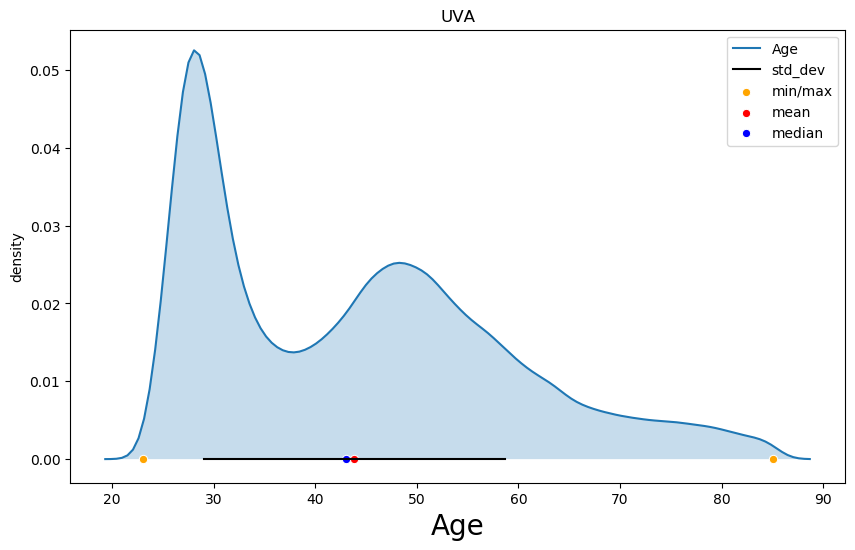

In [75]:
UVA_numeric(total["Age"])

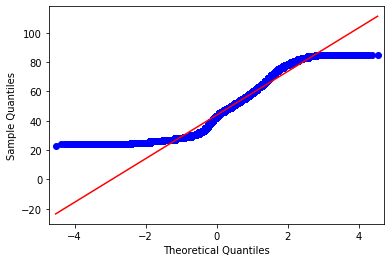

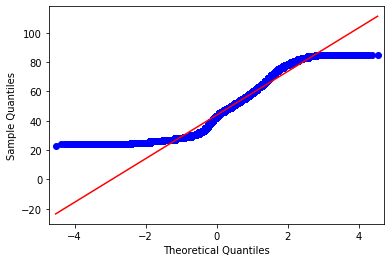

In [76]:
sm.qqplot(total.Age,line='s')

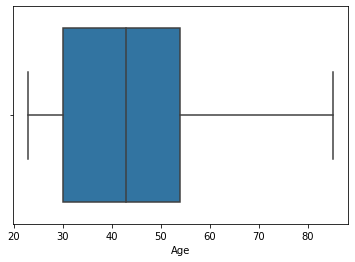

In [147]:
sns.boxplot(total.Age)

Observations:
    * We haven't got straight line in qqplot. So the distribution is not normal distribution.
    * This looks like bimodal distribution, we have to investigate.
    * The skew value is greater than 0.5, hence it is positively skewed and it is evident in the kdeplot. We might have outliers.
    * Kurtosis value is less than zero, which is Platykurtic, which means shorter distribution, the second peak looks fatter and thin tailed which could have contributed to this value.
    

### 5.1.2 Vintage

Minimum                                                     7
Maximum                                                   135
Range                                                     128
Mean                                                  46.9242
Median                                                     32
Standard Deviation                                    32.3293
Skew                                                 0.790512
Kurtosis                                            -0.694312
Points                (14.594941073129782, 79.25354783259812)
dtype: object


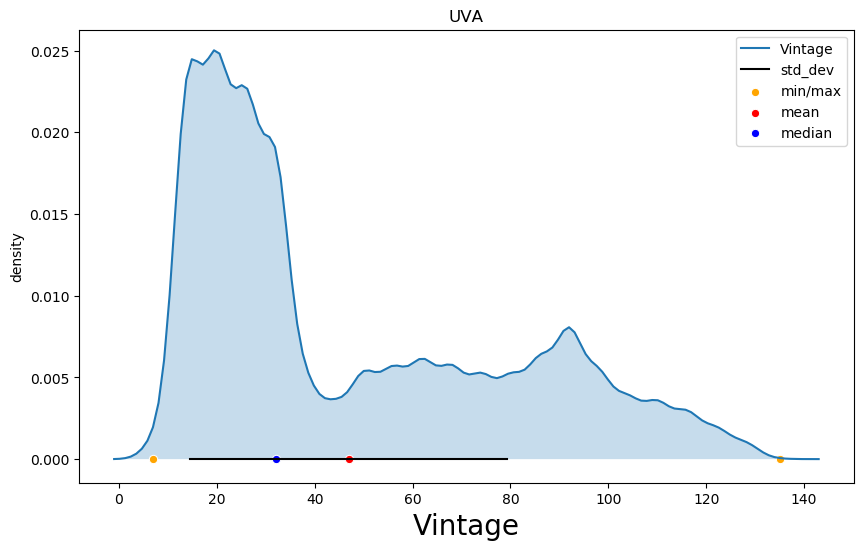

In [77]:
UVA_numeric(total.Vintage)

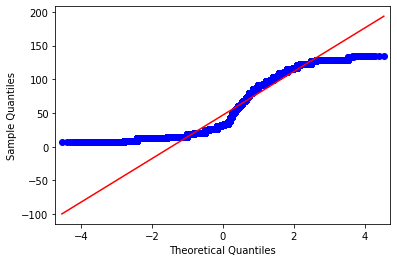

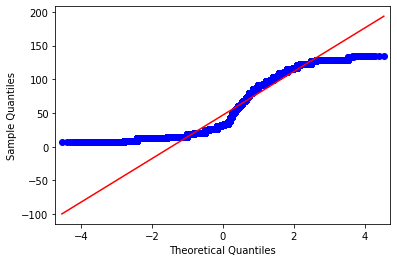

In [78]:
sm.qqplot(total.Vintage,line='s')

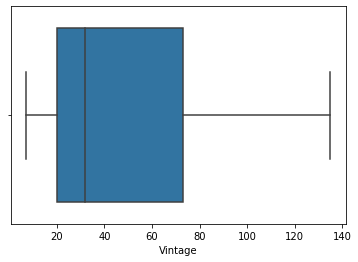

In [146]:
sns.boxplot(total.Vintage)

Observations:
    * We haven't got straight line in qqplot. So the distribution is not normal distribution.
    * This looks like lot of values are there towards right tail, we have to investigate.
    * The skew value is greater than 0.5, hence it is positively skewed and it is evident in the kdeplot. We might have outliers.
    * Kurtosis value is less than zero, which is Platykurtic, which means shorter distribution
    

### 5.1.3 Avg_Account_Balance

Minimum                                                  20790
Maximum                                               10352009
Range                                                 10331219
Mean                                               1.13014e+06
Median                                                  895162
Standard Deviation                                      856953
Skew                                                   2.97817
Kurtosis                                               14.3479
Points                (273187.62487884564, 1987093.5251024952)
dtype: object


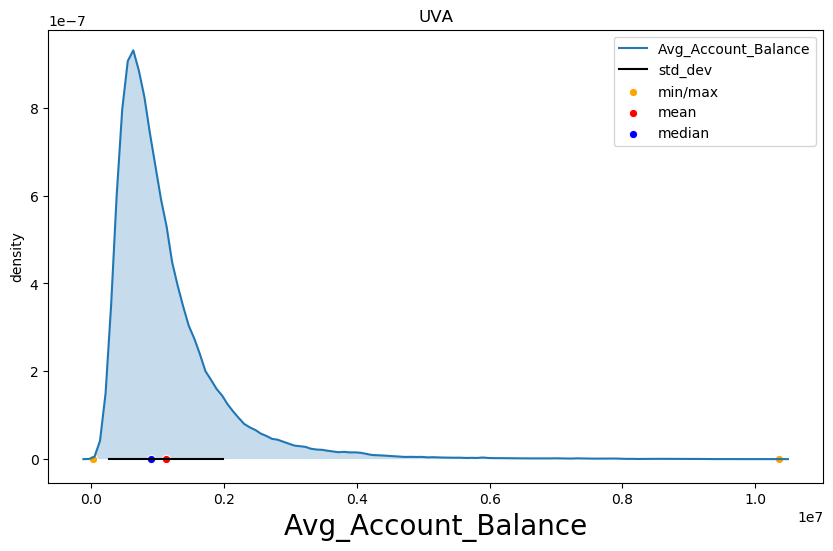

In [79]:
UVA_numeric(total.Avg_Account_Balance)

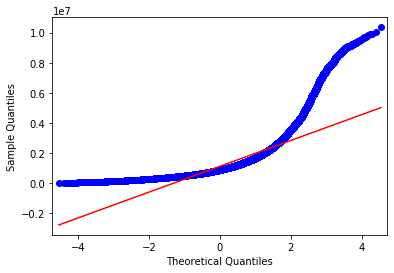

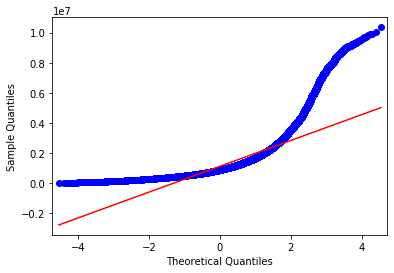

In [80]:
sm.qqplot(total.Avg_Account_Balance,line='s')

Observations:
    * Skew is greater that 0.5, so positive skewed, very evident in the kde plot.
    * Kurtosis is also positive, so Leptokurtic, which mean longer distribution.
    * This also doesnt falls under normal distribution, as we can see from qqplot.
    * There has to be outliers in this column, which contributes to the long right tail.

In [142]:
total[total["Avg_Account_Balance"]>1366666]["Occupation"].value_counts()

Self_Employed    36276
Other            29199
Salaried         20989
Entrepreneur      1492
Name: Occupation, dtype: int64

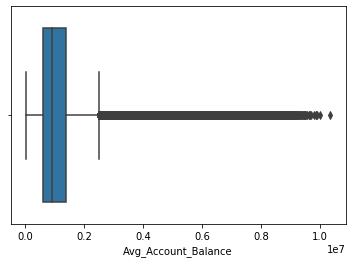

In [145]:
sns.boxplot(total.Avg_Account_Balance)

In [148]:
Q1 = total.Avg_Account_Balance.quantile(0.25)
Q3 = total.Avg_Account_Balance.quantile(0.75)
IQR = Q3-Q1
Q1-1.5*IQR, Q3+1.5*IQR

(-541765.5, 2514102.5)

In [152]:
total[total.Avg_Account_Balance>2514102.5]["Occupation"].value_counts()

Self_Employed    8206
Other            7305
Salaried         4976
Entrepreneur      349
Name: Occupation, dtype: int64

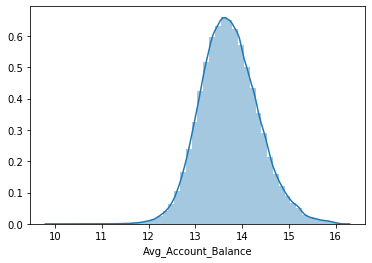

In [176]:
sns.distplot(np.log(total.Avg_Account_Balance))

In [164]:
np.log(total.Avg_Account_Balance).describe()

count    351037.000000
mean         13.734259
std           0.620477
min           9.942227
25%          13.311636
50%          13.704760
75%          14.128971
max          16.152691
Name: Avg_Account_Balance, dtype: float64

In [159]:
from scipy import stats

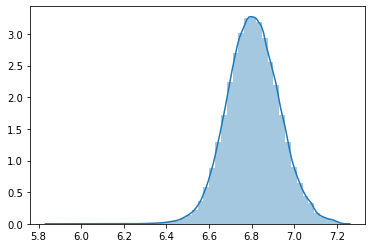

In [180]:
fitted_data, fitted_lambda = stats.boxcox(total.Avg_Account_Balance)
sns.distplot(fitted_data)

## 5.2 Categorical

In [86]:
total.dtypes

ID                     object
Gender                 object
Age                     int64
Region_Code            object
Occupation             object
Channel_Code           object
Vintage                 int64
Credit_Product         object
Avg_Account_Balance     int64
Is_Active              object
Is_Lead                 int64
dtype: object

### 5.2.1 Gender

No. of unique values in Train : 2
No. of unique values in Test : 2
No difference in values


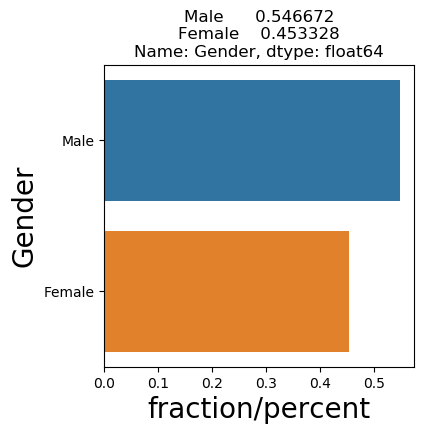

In [102]:
UVA_category(total.Gender,train.Gender,test.Gender)

In [137]:
total.groupby("Gender").mean()

,Age,Vintage,Avg_Account_Balance,Is_Lead
Gender,,,,
Female,41.389518,41.733572,1.108037e+06,-0.156483
Male,45.909959,51.228617,1.148470e+06,-0.115278


### 5.2.2 Region_Code

No. of unique values in Train : 35
No. of unique values in Test : 35
No difference in values


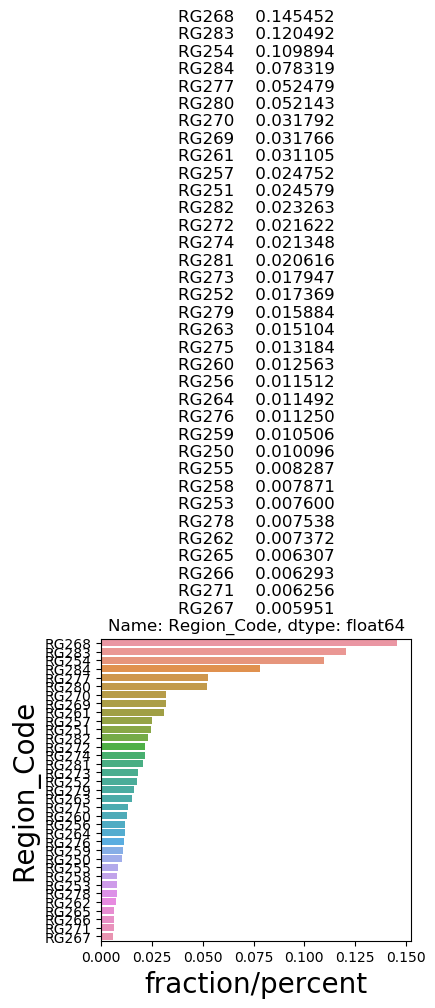

In [103]:
UVA_category(total.Region_Code,train.Region_Code,test.Region_Code)

In [138]:
total.groupby("Region_Code").mean()

,Age,Vintage,Avg_Account_Balance,Is_Lead
Region_Code,,,,
RG250,37.777088,34.849887,7.375830e+05,-0.184819
RG251,43.776889,42.042420,7.421042e+05,-0.150325
RG252,35.670494,32.472199,6.347450e+05,-0.199934
RG253,46.540480,49.087331,1.376685e+06,-0.123313
RG254,43.679524,47.244005,1.411672e+06,-0.156155
RG255,42.755930,42.094534,8.702262e+05,-0.145067
RG256,35.959663,32.374412,6.740368e+05,-0.196239
RG257,39.332374,37.903441,8.607638e+05,-0.163195
RG258,40.998190,37.902280,7.053080e+05,-0.138256


### 5.1.3 Occupation

No. of unique values in Train : 4
No. of unique values in Test : 4
No difference in values


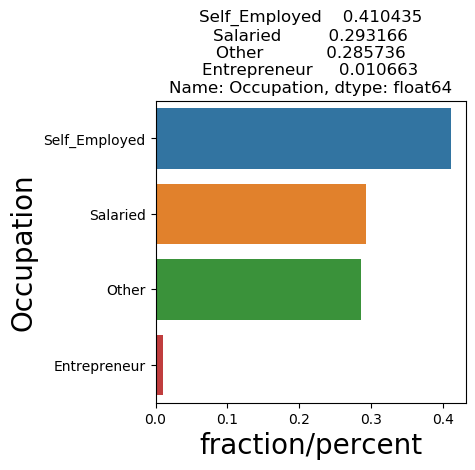

In [104]:
UVA_category(total.Occupation, train.Occupation, test.Occupation)

In [141]:
total.groupby("Occupation")["Is_Lead"].value_counts()

Occupation     Is_Lead
Entrepreneur    1          1762
               -1          1076
                0           905
Other           0         52984
               -1         30131
                1         17189
Salaried        0         60503
               -1         30913
                1         11496
Self_Employed   0         73045
               -1         43192
                1         27841
Name: Is_Lead, dtype: int64

### 5.2.4 Channel_Code

No. of unique values in Train : 4
No. of unique values in Test : 4
No difference in values


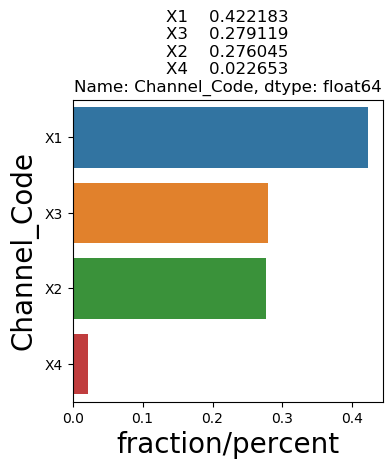

In [105]:
UVA_category(total.Channel_Code, train.Channel_Code, test.Channel_Code)

### 5.2.5 Credit_Product

No. of unique values in Train : 2
No. of unique values in Test : 2
Values present in Train dataset but not missing Test dataset : [nan]
Values present in Test dataset but missing in Train dataset : [nan]


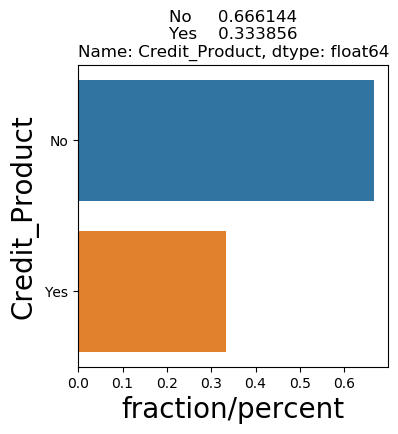

In [106]:
UVA_category(total.Credit_Product, train.Credit_Product, test.Credit_Product)

### 5.2.6 Is_Active

No. of unique values in Train : 2
No. of unique values in Test : 2
No difference in values


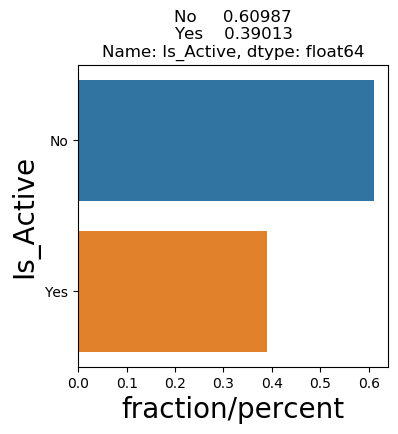

In [107]:
UVA_category(total.Is_Active, train.Is_Active, test.Is_Active)

#  Bivariate Analysis

## Numerical - Numerical

In [108]:
numerical = ["Age", "Vintage", "Avg_Account_Balance"]

Correlation Matrix

In [110]:
correlation = total[numerical].dropna().corr()
correlation

,Age,Vintage,Avg_Account_Balance
Age,1.000000,0.628558,0.142563
Vintage,0.628558,1.000000,0.166611
Avg_Account_Balance,0.142563,0.166611,1.000000


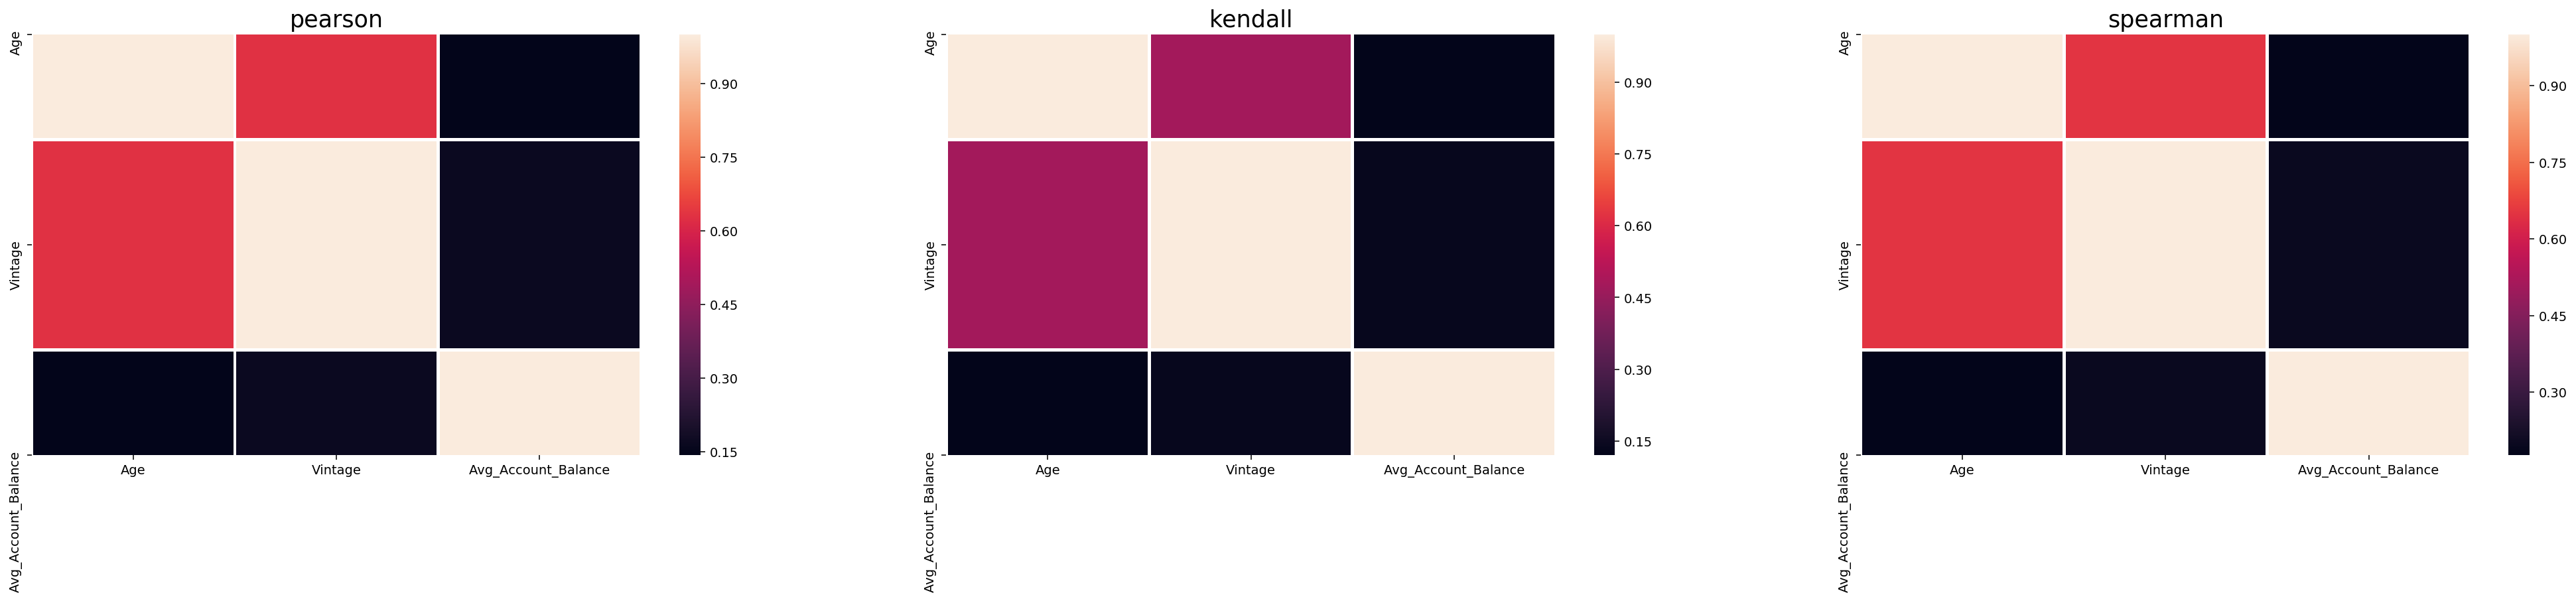

In [111]:
plt.figure(figsize=(36,6), dpi=140)
for j,i in enumerate(['pearson','kendall','spearman']):
    plt.subplot(1,3,j+1)
    correlation = total[numerical].dropna().corr(method=i)
    sns.heatmap(correlation, linewidth = 2)
    plt.title(i, fontsize=18)

In [118]:
correlation = train[["Age", "Vintage", "Avg_Account_Balance","Is_Lead"]].dropna().corr(method="kendall")
correlation

,Age,Vintage,Avg_Account_Balance,Is_Lead
Age,1.000000,0.477790,0.121379,0.210291
Vintage,0.477790,1.000000,0.134562,0.208096
Avg_Account_Balance,0.121379,0.134562,1.000000,0.063248
Is_Lead,0.210291,0.208096,0.063248,1.000000


    * Age and Vintage have high positive correlation
    * Avg_Account_Balance is having a slight correlation with other two.

Scatterplot

<Figure size 840x560 with 0 Axes>

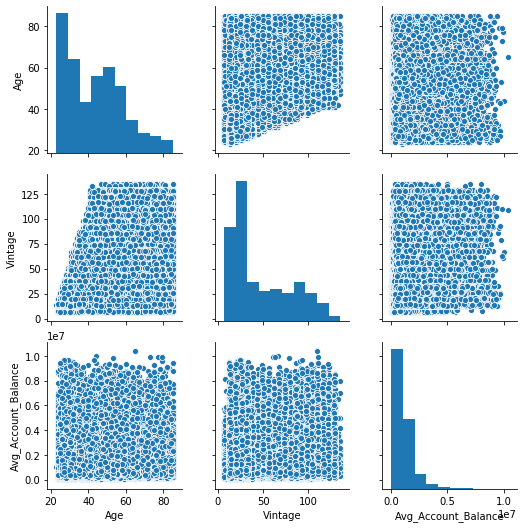

In [119]:
plt.figure(dpi=140)
sns.pairplot(total[numerical])